In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split

In [4]:
from matplotlib.font_manager import FontProperties
import seaborn as sns

In [5]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
import os
import pandas as pd
import torch

In [7]:
import Hartmannb

The result of custom_function at [0.95, 0.95, 0.95, 0.95, 0.95, 0.95] is 0.00011397265188861638


In [8]:
from botorch.test_functions.base import BaseTestProblem
from botorch.test_functions import Hartmann
import numpy as np 
import torch 
import random 
from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
# from botorch.fit import fit_gpytorch_model 
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.acquisition import qLogNoisyExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
import os

In [11]:
from scipy import stats

In [17]:
# 读取 Excel 文件
df = pd.read_csv('data.csv')  # 替换为你的文件名和工作表名

# 显示数据
print(df.head())

            G           F            W          V1          V2         V3  \
0  960.274125   85.293927  6623.437770  214.227575  340.372233  54.603440   
1  959.872112   85.745979  6595.996008  213.992957  332.089900  54.645951   
2  960.379664   86.963096  6622.916667  214.070897  343.915356  54.703336   
3  960.241819   94.040876  6654.799367  214.146170  339.090909  54.797417   
4  955.264501  101.057077  6768.130288  214.118549  369.283862  54.841628   

          C  
0  0.089293  
1  0.090599  
2  0.097921  
3  0.105241  
4  0.119251  


In [45]:
x = df[['G', 'V1', 'V2', 'V3',
        ]]
y = df[['C']]
y1 =df[['F', 'W']]

In [46]:
# 将 y 分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# 打印 y_train 和 y_test 的大小
print(f"Training labels size: {y_train.shape}")
print(f"Test labels size: {y_test.shape}")

Training labels size: (2610, 1)
Test labels size: (290, 1)


In [48]:
# 创建随机森林模型
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)  # 可以根据需要调整参数

# 拟合模型
rf_model.fit(x_train, y_train)

# 在训练集和测试集上进行预测
y_train_pred = rf_model.predict(x_train)
y_test_pred = rf_model.predict(x_test)

# 输出训练集和测试集的 R² 值
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training R²: {train_r2}")
print(f"Test R²: {test_r2}")

C:\Users\10925\AppData\Local\Temp\ipykernel_4204\600102426.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Training R²: 0.9553807351603261
Test R²: 0.7581741667407587


In [101]:
def predict_function(new_data):
    """给定新的 4 维输入数据，返回预测值"""
    # 将输入数据转换为 NumPy 数组
    new_data_numpy = new_data.cpu().numpy().astype(np.float64)  
    
    # 将 NumPy 数组转换为 pandas DataFrame，并提供列名
    feature_names = ['G', 'V1', 'V2', 'V3']  # 使用你的特征名称
    new_data_df = pd.DataFrame(new_data_numpy, columns=feature_names)
    
    # 使用随机森林模型进行预测
    predictions = rf_model.predict(new_data_df)
    
    return torch.tensor(predictions, dtype=torch.float64)  # 返回 PyTorch 张量，确保为 float32

In [93]:
def generate_random_4d_tensor(n_samples, bounds, device):
    """
    生成一组随机的 4 维张量数据。
    
    参数:
    - n_samples: 生成的样本数量
    - bounds: 每个维度的上下界，格式为 [(low1, high1), (low2, high2), (low3, high3), (low4, high4)]
    - device: 要将张量移动到的设备（例如 'cuda:0' 或 'cpu'）
    
    返回:
    - 生成的随机 4 维张量数据，形状为 (n_samples, 4)
    """
    # 检查 bounds 是否为 4 维
    if len(bounds) != 4:
        raise ValueError("bounds 参数必须包含 4 维的上下界")
    
    # 生成随机数据
    random_data = torch.empty((n_samples, 4), device=device)
    for i, (low, high) in enumerate(bounds):
        random_data[:, i] = torch.FloatTensor(n_samples).uniform_(low, high).to(device)
    
    return random_data

bounds = [(900, 1200),  # 第一维度的范围
          (0, 372),    # 第二维度的范围
          (0, 740),    # 第三维度的范围
          (0, 126)]    # 第四维度的范围

# 选择设备
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# 存储所有生成的样本
all_random_tensor_data = []

# 生成 10 次随机样本，每次 5 个
for _ in range(10):
    random_tensor_data = generate_random_4d_tensor(n_samples=5, bounds=bounds, device=device)
    all_random_tensor_data.append(random_tensor_data)

# 打印所有生成的随机张量数据
for i, tensor in enumerate(all_random_tensor_data):
    print(f"Sample set {i + 1}:\n{tensor}\n")

Sample set 1:
tensor([[9.0363e+02, 9.5914e+00, 1.9121e+02, 5.1636e+01],
        [9.4350e+02, 2.6118e+02, 6.5100e+02, 5.9048e+01],
        [9.0395e+02, 2.4478e+02, 4.8201e-01, 9.6685e+01],
        [1.0267e+03, 1.3522e+02, 1.7178e+01, 1.0577e+02],
        [1.1733e+03, 1.7421e+02, 6.1369e+02, 1.1721e+02]], device='cuda:0')

Sample set 2:
tensor([[1123.7202,   35.0911,  454.3852,   28.5838],
        [ 915.6410,    8.4353,  413.8771,   16.1623],
        [1045.1238,  282.6217,  139.3568,  111.7259],
        [1056.0535,  227.9230,  120.7081,   35.1820],
        [1068.0309,   81.1042,  553.0591,   68.5092]], device='cuda:0')

Sample set 3:
tensor([[ 952.5308,   73.1453,  556.9059,  125.0425],
        [1150.3746,  325.1776,  528.5088,   15.4156],
        [ 939.9727,  282.9708,  424.1212,   17.0404],
        [1131.8425,  320.9527,  713.7481,   48.2101],
        [1135.8186,  320.4098,  139.3037,   27.3896]], device='cuda:0')

Sample set 4:
tensor([[1123.6847,   20.8690,  233.5528,   27.0059],
   

In [95]:
def fit_gp_model_and_select_next_point1(train_x, train_obj, device):
    # 确保 train_x 和 train_obj 是 float64 类型
    train_x = train_x.to(device=device, dtype=torch.float64)
    train_obj = train_obj.to(device=device, dtype=torch.float64)

    # 创建和拟合高斯过程模型
    model = SingleTaskGP(
        train_X=train_x,
        train_Y=train_obj,
        input_transform=Normalize(d=train_x.shape[1]),  # 使用输入的维度
        outcome_transform=Standardize(m=1),  # 输出为一维
    ).to(device)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # 找到当前最优值
    best_value = train_obj.max()

    # 定义 Log Expected Improvement
    qLogEI = qLogExpectedImprovement(model=model, best_f=best_value)

    # 修改为你指定的上下界
    lower_bounds = [900, 0, 0, 0]  # 对应 4 维输入
    upper_bounds = [1200, 372, 740, 126]  # 对应 4 维输入

    # 转换为 tensor，确保数据类型为 float64
    bounds = torch.tensor([lower_bounds, upper_bounds], device=device, dtype=torch.float64)

    # 优化获取函数，找到新的采样点
    new_point_analytic, _ = optimize_acqf(
        acq_function=qLogEI,
        bounds=bounds,
        q=1,  # 采样一个点
        num_restarts=20,
        raw_samples=100,
        options={},
    )
    
    return new_point_analytic.squeeze(0)


In [104]:
results1 = Hartmannb.bayesian_optimization_experiment(
    num_experiments=10,
    n=50,
    obj_fn1=predict_function,
    obj_fn2=None, 
    obj_fn3=predict_function,
    initial_points_task1=all_random_tensor_data,

    fit_task_fn=fit_gp_model_and_select_next_point1,
    device='cuda',
    task_type='single'  # 表示运行单任务模型
)

tensor([[9.0363e+02, 9.5914e+00, 1.9121e+02, 5.1636e+01],
        [9.4350e+02, 2.6118e+02, 6.5100e+02, 5.9048e+01],
        [9.0395e+02, 2.4478e+02, 4.8201e-01, 9.6685e+01],
        [1.0267e+03, 1.3522e+02, 1.7178e+01, 1.0577e+02],
        [1.1733e+03, 1.7421e+02, 6.1369e+02, 1.1721e+02]], device='cuda:0')
Nr. of optimization run: 0
New candidates are: tensor([[900.0000, 298.4674,   0.0000, 100.0868]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 1.67 seconds
Nr. of optimization run: 1
New candidates are: tensor([[900.0000, 213.5717,   0.0000,  85.2511]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 4.30 seconds
Nr. of optimization run: 2
New candidates are: tensor([[900.0000, 223.6933,   0.0000, 107.7862]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 4.25 seconds
Nr. of optimization run: 3
New candidates are: tensor([[968.2325, 280.3899,   0.0000,  95.8588]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 3.47 seconds


In [105]:
results_list = [results1]
results_names = ['results1']

# 初始化一个空字典来存储展平后的数据
flattened_results = {}

# 遍历所有结果数组
for i, results in enumerate(results_list):
    if isinstance(results, torch.Tensor):
        results_np = results.cpu().numpy()  # 转为 numpy 数组
    else:
        results_np = results  # 如果已经是 numpy 数组，直接使用
    
    # 获取数组的维度
    shape_len = len(results_np.shape)
    
    if shape_len == 3:
        # 3D 数组的形状 (num_experiments, num_samples, num_metrics)
        num_experiments, num_samples, num_metrics = results_np.shape
        # 展平为 2D 数组
        flattened_array = results_np.reshape(num_experiments * num_samples, num_metrics)
    elif shape_len == 2:
        # 2D 数组的形状 (num_experiments, num_metrics)
        flattened_array = results_np
        num_experiments, num_metrics = flattened_array.shape
    else:
        raise ValueError(f"Unexpected number of dimensions: {shape_len}")
    
    # 将每个数组的列命名为 'results1_Metric_1', 'results1_Metric_2', ...
    columns = [f"{results_names[i]}_Metric_{j+1}" for j in range(num_metrics)]
    
    # 将展平后的数组存入字典，方便后面转换为 DataFrame
    flattened_results.update({col: flattened_array[:, j] for j, col in enumerate(columns)})

# 创建 DataFrame
df_results = pd.DataFrame(flattened_results)

# 文件名
csv_filename = '实验数据二'

# 检查 CSV 文件是否已经存在
if os.path.exists(csv_filename):
    # 如果文件存在，先读取现有文件
    df_existing = pd.read_csv(csv_filename)
    # 合并新结果到现有的 DataFrame 中
    df_results = pd.concat([df_existing, df_results], ignore_index=True)

# 保存或追加为 CSV 文件
df_results.to_csv(csv_filename, index=False)

print(f"所有结果已保存到 {csv_filename} 文件中。")

所有结果已保存到 实验数据二 文件中。


In [20]:
def load_and_plot_individual_results(csv_files, confidence_level=0.95):
    """
    参数:
    - csv_files: CSV 文件名的列表。
    - confidence_level: 置信水平，默认值为 0.95。
    """
    # 计算置信区间的 Z 值
    z_value = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    # 准备线条颜色和标签
    line_colors = ['blue']
    line_styles = ['-']  # 为每一条线添加样式
    labels = ['mokuangshuju']

    # 创建一个包含 2x2 网格的图形
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    for idx, csv_filename in enumerate(csv_files):
        # 检查 CSV 文件是否存在
        if not os.path.exists(csv_filename):
            raise FileNotFoundError(f"File {csv_filename} does not exist.")

        # 从 CSV 文件中读取数据
        df_results = pd.read_csv(csv_filename)



        means_bayes1 = df_results.filter(like='results1_Metric_').mean(axis=0)
        standard_errors1 = df_results.filter(like='results1_Metric_').sem(axis=0)
        ci_bayes1 = z_value * standard_errors1

        
        # x轴的索引
        x = np.arange(len(means_bayes1))

        # 找到对应的子图位置
        ax = axs[idx // 2, idx % 2]

        # 使用不同颜色绘制带有误差条的均值图
        ax.errorbar(x, means_bayes1, yerr=ci_bayes1, fmt='o', label='STGP+qlogEI', 
                    color=line_colors[0], linestyle=line_styles[0], ecolor=line_colors[0], capsize=5)
        
        # 设置子图的标题和标签
        ax.set_title(f'Optimal values and confidence intervals ({labels[idx]})')
        ax.set_xlabel('Number of Iterations')
        ax.set_ylabel('The optimal value')

        # 添加图例
        ax.legend()

    # 调整布局
    fig.tight_layout()

    # 保存图像
    plt.savefig('Ackley_Cos_Hartmann_Individual_Plots_Colored_Lines.png', dpi=300)
    # 显示图形
    plt.show()

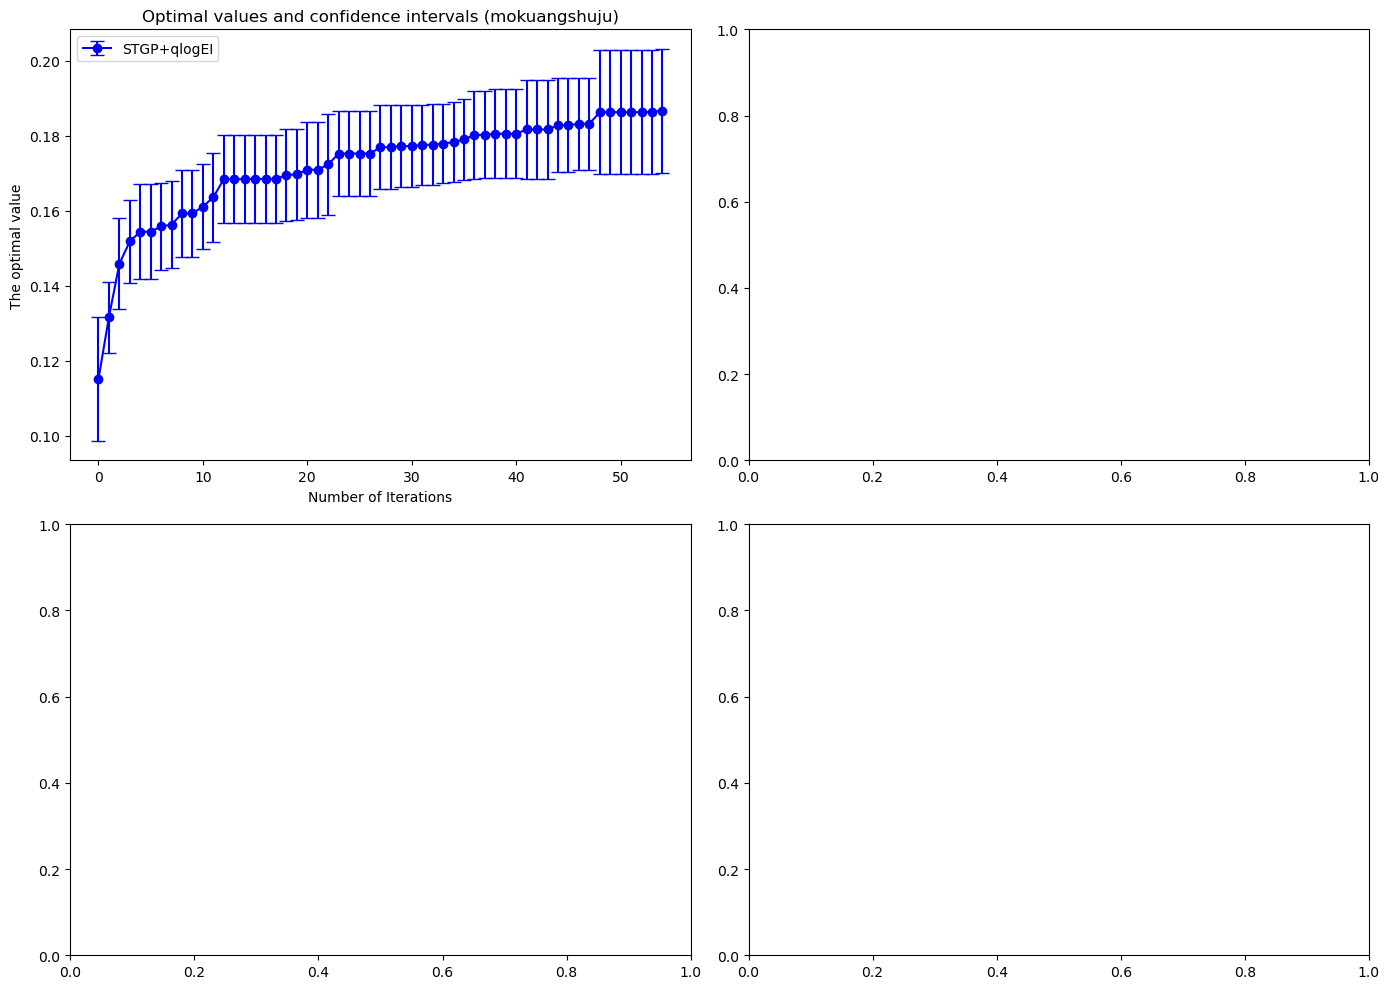

In [21]:
# 定义文件名列表
csv_files = [ '实验数据二']

# 调用函数并绘图
load_and_plot_individual_results(csv_files)